# Mod 5 Project: 
## Classifying whether or not a Floodlight Open Participant has multiple sclerosis

Fisrt, let's import necessary packages and read in our cleaned dataframe.

In [9]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV


In [4]:
maindf = pd.read_csv('maindf.csv')

As you can see below, we have our diagnosis classification as well as a variety of tests from the Floodlight Open data, gender, country of residence, age and BMI.

In [7]:
maindf.head()

,floodlightOpenId,diagnosis,mood_mean,bottomtop_mean,circle_mean,figure8_mean,meandrawdist_mean,numshapes_mean,spiral_mean,square_mean,...,male,AU,CA,CH,CZ,DK,ES,GB,IT,US
0,FL00043910,HC,3.200000,0.435455,0.467273,0.463636,0.438333,0.416667,0.496364,0.536364,...,1,0,1,0,0,0,0,0,0,0
1,FL00088674,MS,4.000000,0.130000,0.140000,0.120000,0.150000,2.000000,0.170000,0.230000,...,1,0,1,0,0,0,0,0,0,0
2,FL00277926,MS,3.000000,0.136667,0.140000,0.123333,0.156667,2.333333,0.170000,0.230000,...,1,0,0,0,0,0,0,0,0,1
3,FL00497704,MS,3.000000,0.130000,0.120000,0.130000,0.150000,1.000000,0.160000,0.220000,...,0,0,0,0,0,0,0,0,0,1
4,FL00631304,MS,4.571429,0.138571,0.111429,0.111429,0.148571,4.428571,0.168571,0.214286,...,0,0,1,0,0,0,0,0,0,0


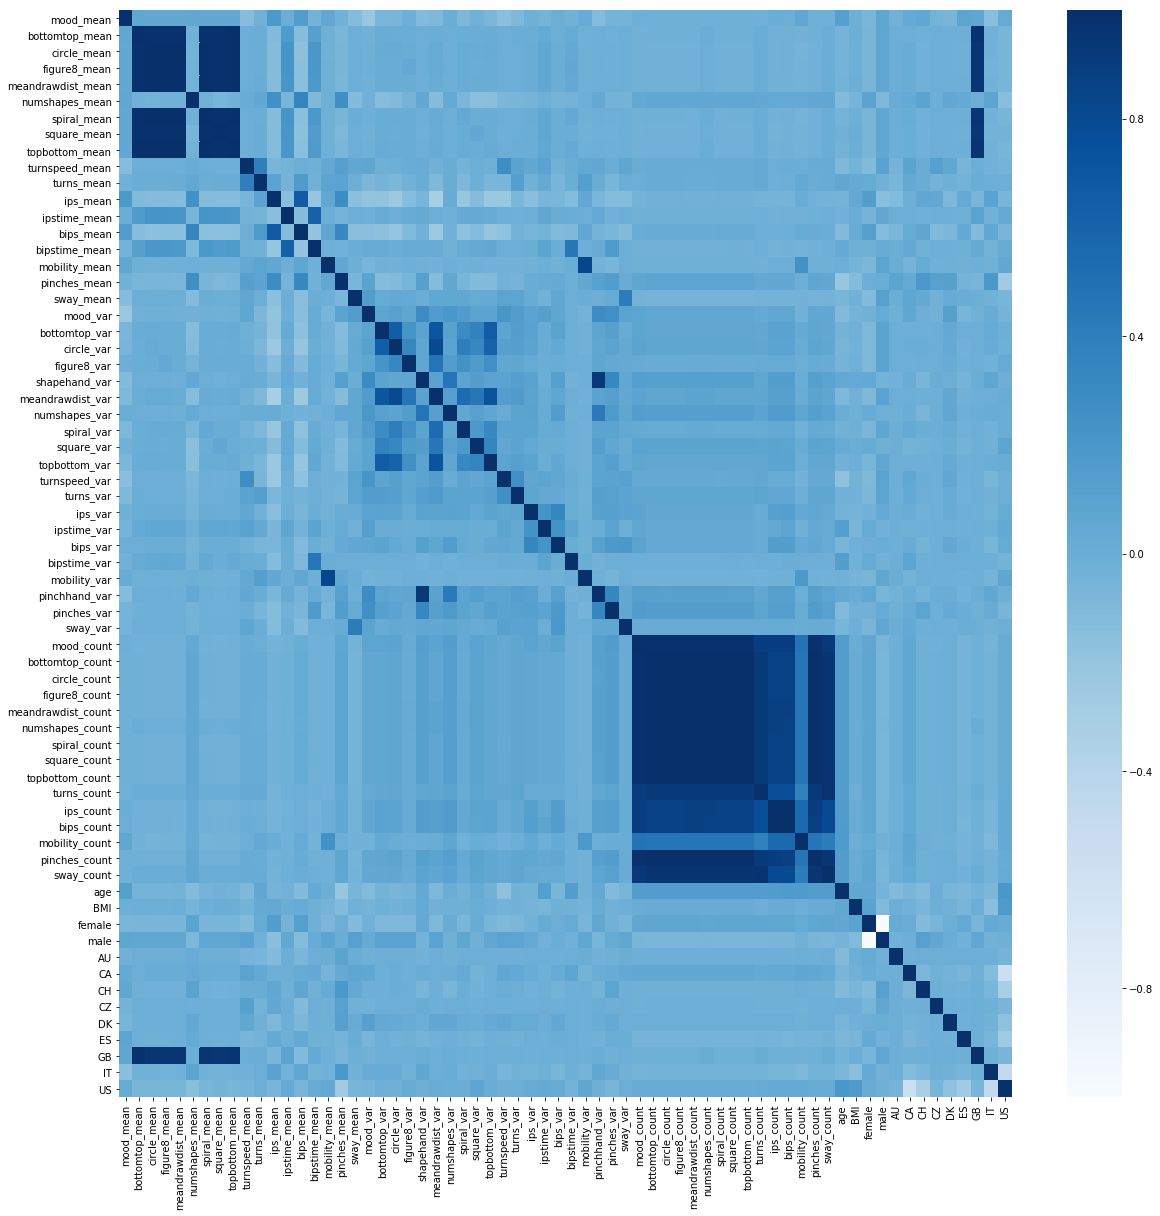

In [25]:
plt.figure(figsize = (20, 20))
sns.heatmap(maindf.corr(), cmap = 'Blues')

KeyboardInterrupt: 

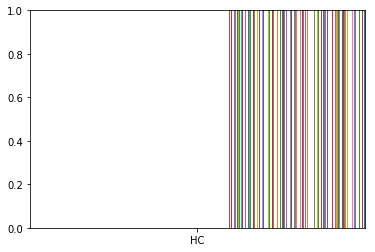

In [19]:
plt.hist(maindf['diagnosis'])